# Natural Language Processing (NLP)
## Classifiying SMS Spam
First we have to install nltk. 

Second, we download data from UCI, SMS SSpam Collection Data Set.

https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

__I alrady download that and put the files in the **datasets** folder.__


## The big picture, what are we going to do here?
At this point, we have learnt many classifiers. We need to train them with train data.

The train data shall have features and label. For the dataset here, we will see that they come with label already. They also provide SMS messages. The sms is string. We will try to convert these strings to something measurable and meaningful. We will create features from the message. Hopefully, the classifiers can utilize these features in the training process. This is also call **FEATURE ENGINEERING**.


# Feature Engineering
First, let's load data and see what features we can construct from the string.

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns

In [84]:
# Load data from the file into a dataframe
data = pd.read_csv('./datasets/SMSSpamCollection', sep = '\t', header=None, names=["label", "sms"])
data.head(3)

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [85]:
# Re-arrange the columns such that label is the last one
df = pd.DataFrame()
df["text"] = data.sms
df["label"] = data.label

In [86]:
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [87]:
df.describe()

,text,label
count,5572,5572
unique,5169,2
top,"Sorry, I'll call later",ham
freq,30,4825


In [88]:
# Notice the proportion of ham vs spam. If one class is too small, the training process might not go well.
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

## Can't we just use the text as our feature?
Each sms message is a series of characters. Those characters may form sentence(s), emoji, paragraph.

Since we need numbers to be used to train the classifier, how can we convert to text to a number.

### IDEA#1 : 
Replace each text with a number (aka: a is 1, b is 2,.... z is 26)

1-5     6-10  11-15 16-20 21-25 26

abcde fghij klmno pqrst uvwxy z

fun : can be represented as:   f->6 u->21 n->14 = 62114

This idea sounds good at first but if we look at the values. The hardly represent the original meaning.

Ex:

go : 715

went : 2351420

tasty : 201192025

yummy : 2521131325

Here, we just look at very simple words. Imagine that we have the whole sentence, the value will be greatly different even the meaning is 99% the same.

### IDEA#2 : 
We count the length of each text (sms)


In [89]:
# Let's try with one simple word
aaa = "Hello"
len(aaa)

5

In [90]:
# Now we calculate the length of all messages
df['length']=df['text'].apply(len)
df.head()

,text,label,length
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,ham,49
4,"Nah I don't think he goes to usf, he lives aro...",ham,61


In [91]:
# The average length of the messages
df['length'].mean()

80.48994974874371

## Whitespace
The length can be misleading if there are whitespace characters. This dataset doesn't have problems with whitespace. However, let's see if we need to. clean that how could we do it.


In [92]:
# Let's strip whitespace out
"   HELLO MUIC ".strip()

'HELLO MUIC'

In [93]:
df['textstripped']=df['text'].str.strip()
df['lengthstripped']=df['textstripped'].apply(len)
df['lengthdiff']=df['length']-df['lengthstripped']
df['lengthdiff'].head()

0    0
1    0
2    0
3    0
4    0
Name: lengthdiff, dtype: int64

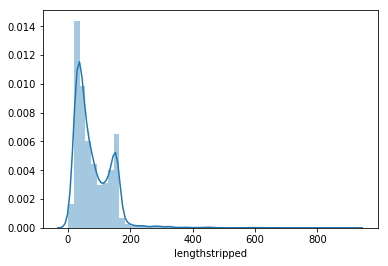

In [94]:
# Let's visualize the data
sns.distplot(df['lengthstripped'])

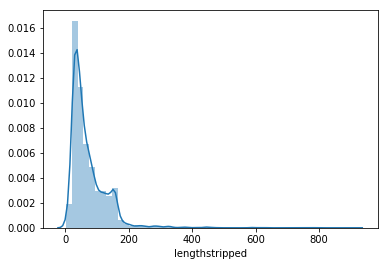

In [95]:
ham = df[df['label']=='ham']
spam = df[df['label']=='spam']
sns.distplot(ham['lengthstripped'])

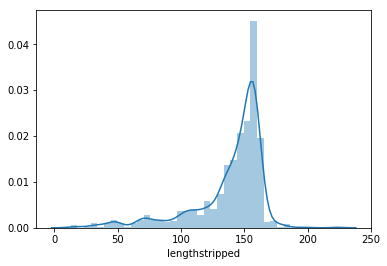

In [96]:
sns.distplot(spam['lengthstripped'])

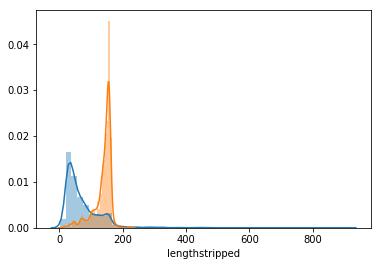

In [97]:
sns.distplot(ham['lengthstripped'])
sns.distplot(spam['lengthstripped'])

At this point, the length may be used to classify the SMS messages. However, the performance may not be that good.

## Let's process the data in a advanced way

In [98]:
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt') # tokenizer

[nltk_data] Downloading package stopwords to /Users/tix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Stop Words

In [99]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [100]:
# Let's take a look at some stop words
stopwords[50:60]

['been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing']

## Punctuation

In [101]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Pre process data

In [102]:
def pre_process(sms):
   # first, we move the punctuation
   remove_punct = "".join([word.lower() for word in sms if word not 
                  in punctuation])
   # second, we chop the into words
   tokenize = nltk.tokenize.word_tokenize(remove_punct)
   # we remove the words that don't carry much meaning (aka: they are too general)
   remove_stopwords = [word for word in tokenize if word not in
                       stopwords]
   return remove_stopwords


In [103]:
#Let's test it
pre_process("I am a student.")

['student']

In [104]:
pre_process("I am a student at MUIC. I am learning about NLP today.")

['student', 'muic', 'learning', 'nlp', 'today']

In [105]:
pre_process("I am a student at MUIC. I am learning about NLP today. Now all students can join.")

['student', 'muic', 'learning', 'nlp', 'today', 'students', 'join']

In [106]:
temp = pre_process("I am studying this. Some studied about this before. Some will study next term.")
temp

['studying', 'studied', 'study', 'next', 'term']

In [107]:
df['textstripped'].head(3).apply(pre_process)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
Name: textstripped, dtype: object

## Vectorize
With all the remaining words, we give id to each word. So, for each message, we will represents with the IDs of the words in that message.

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

In [109]:
# Let's create a transformer
bow_transformer = CountVectorizer(analyzer=pre_process).fit(df['textstripped'])

In [110]:
len(bow_transformer.vocabulary_)

9506

In [111]:
# Let's try a transformer
# Will randomly pick one SMS from the index 555
# Even if this is just a random message... I will call this the chosen sms !!!
the_chosen_sms = df['textstripped'][555]
the_chosen_sms

'I‘ll have a look at the frying pan in case it‘s cheap or a book perhaps. No that‘s silly a frying pan isn‘t likely to be a book'

In [112]:
the_chosen_sms_bow = bow_transformer.transform([the_chosen_sms])

In [113]:
print(the_chosen_sms_bow)

  (0, 1713)	2
  (0, 2020)	1
  (0, 2108)	1
  (0, 3623)	2
  (0, 4996)	1
  (0, 5088)	1
  (0, 6160)	2
  (0, 6273)	1
  (0, 7467)	1
  (0, 9501)	4


In [114]:
# Let's see the 
bow_transformer.get_feature_names()[1713]

'book'

In [115]:
bow_transformer.get_feature_names()[9501]


'‘'

## TF-IDF
Words represent something deeper than just "having" the word or "not having" the word. Hans Peter Luhn suggested that we can try to identify that the word is important or not base on the context of the messages.

TF (Term Frequency) : # of that terms / # all terms in that documents

IDF (Inverse Document Frequency) : Log( number of documents / number of documents having this keyword )

TF-IDF = TF x IDF

In [121]:
# Let's transform and get the count of all messages
sms_bow = bow_transformer.transform(df['textstripped'])

In [122]:
type(sms_bow)

scipy.sparse.csr.csr_matrix

In [123]:
sms_bow.shape

(5572, 9506)

In [124]:
# let's see non-zero
sms_bow.nnz

50198

In [125]:
from sklearn.feature_extraction.text import TfidfTransformer

In [126]:
tfidf_tfm = TfidfTransformer().fit(sms_bow)

In [127]:
# let's transform the_sms
tfidf_the_chosen_sms = tfidf_tfm.transform(the_chosen_sms_bow)

In [128]:
print(tfidf_the_chosen_sms)

  (0, 9501)	0.5936254801026182
  (0, 7467)	0.21297259302845367
  (0, 6273)	0.20330536064874724
  (0, 6160)	0.42594518605690734
  (0, 5088)	0.14686762139154752
  (0, 4996)	0.19644635011922718
  (0, 3623)	0.4066107212974945
  (0, 2108)	0.1723274286802215
  (0, 2020)	0.1649326129348811
  (0, 1713)	0.31160237154198994


In [48]:
# Now, do it for all
data_tfidf = tfidf_tfm.transform(sms_bow)

In [132]:
data_tfidf.shape

(5572, 9506)

# Train the model

In [133]:
from sklearn.naive_bayes import MultinomialNB

In [134]:
clf = MultinomialNB().fit(data_tfidf, df['label'])

In [53]:
clf.predict(the_chosen_sms_bow)

array(['ham'], dtype='<U4')

We can do all the steps above easily using Pipeline

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['textstripped'], df['label'])

In [55]:
 from sklearn.pipeline import Pipeline

In [56]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=pre_process)),
    ('tfidf',TfidfTransformer()),
    ('classify',MultinomialNB())
])

In [57]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function pre_process at 0x7fd125908598>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=Non..._tf=False, use_idf=True)), ('classify', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [58]:
predictions = pipeline.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predictions,y_test)

array([[1210,   58],
       [   1,  124]])

In [60]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1268
        spam       0.68      0.99      0.81       125

   micro avg       0.96      0.96      0.96      1393
   macro avg       0.84      0.97      0.89      1393
weighted avg       0.97      0.96      0.96      1393

